# Trying to better understand how ESmu is calculated

In [1]:
### Load libraries
import loompy
import os
import sem.es as es
import numpy as np
import pandas as pd
import datetime

In [11]:
metrics = ['ges', 'si', 'ss', 'tstat']

ESW_dict = {}
ESW_star_dict = {}
ESW_pvals_dict = {}

for m in metrics:
    ESW_dict[m] = pd.read_csv('out_relevance/cell_type.{}.esw.190722.mapped.csv.gz'.format(m), index_col = 0)
    ESW_star_dict[m] = pd.read_csv('out_relevance/cell_type.{}.esw_s.190722.mapped.csv.gz'.format(m), index_col = 0)
    ESW_pvals_dict[m] = pd.read_csv('out_relevance/cell_type.{}.pvals.190722.mapped.csv.gz'.format(m), index_col = 0)

In [12]:
ESW_star_dict['tstat'].head()

,Bladder.bladder_cell,Bladder.bladder_urothelial_cell,Brain_Myeloid.macrophage,Brain_Myeloid.microglial_cell,Brain_Non-Myeloid.Bergmann_glial_cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain_pericyte,Brain_Non-Myeloid.endothelial_cell,Brain_Non-Myeloid.neuron,Brain_Non-Myeloid.oligodendrocyte,...,Spleen.macrophage,Thymus.DN1_thymic_pro-T_cell,Thymus.immature_T_cell,Thymus.leukocyte,Tongue.basal_cell_of_epidermis,Tongue.keratinocyte,Trachea.blood_cell,Trachea.endothelial_cell,Trachea.epithelial_cell,Trachea.mesenchymal_cell
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000081791,0.000000,0.000000,0.000000,0.103266,0.000000,0.086587,0.464213,0.639837,0.158826,0.435695,...,0.0,0.0,0.000000,0.0,0.592537,0.00000,0.0,0.000000,0.0,0.000000
ENSG00000162929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.651252,0.343265,...,0.0,0.0,0.000000,0.0,0.058872,0.00000,0.0,0.198195,0.0,0.395377
ENSG00000168887,0.000000,0.000000,0.000000,0.225949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.549686,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000
ENSG00000162384,0.667635,0.316803,0.000000,0.000000,0.000000,0.000000,0.000000,0.600519,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.137977,0.19666,0.0,0.000000,0.0,0.328252
ENSG00000154274,0.000000,0.828578,0.610104,0.956752,0.621849,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000


In [15]:
print((ESW_star_dict['si']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_star_dict['ges']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_star_dict['ss']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_star_dict['tstat']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_star_dict['si']["Bladder.bladder_cell"] > 0).value_counts())
print((ESW_star_dict['tstat']["Bladder.bladder_cell"] > 0).value_counts())

False    12679
True      1623
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    8537
True     5765
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    10993
True      3309
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    8031
True     6271
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    12916
True      1386
Name: Bladder.bladder_cell, dtype: int64
False    10514
True      3788
Name: Bladder.bladder_cell, dtype: int64


OK, as I expected after comparing for significance we do indeed get a different number of genes which are significant between metrics. If ESmu is then simply the mean of all the metrics then it should have greater than or equal to genes than any of the individual metrics.

In [16]:
ESmu = pd.read_csv('out_relevance/cell_type.esmu.190722.mapped.csv.gz', index_col = 0)

In [17]:
(ESmu["Brain_Non-Myeloid.neuron"] > 0).value_counts()

False    7573
True     6729
Name: Brain_Non-Myeloid.neuron, dtype: int64

It does indeed seem that ESmu is simply the mean across all metrics thus genes that are only specific in one metric will still be included in the final ESmu metric but with little weighting. In order to quantile normalise the metrics I will need to take the original metrics (ESw)

OK - lets take a look at the distribution of ESw, ESW_star, ESmu and min-max normalised ESw. Because I need a way to get these values into a 0-1 range and min-max normalisation makes the most sense to me but **preservation of distribution is of utmost importance** so I should at least take a peak at the data to ensure this isn't ruining the shape prior to trying out quantile normalisation.

In [18]:
import matplotlib.pyplot as plt

### Check out distribution of an ESw* and ESmu

(array([1642., 1414.,  938.,  625.,  550.,  425.,  267.,  290.,  292.,
         286.]),
 array([3.98660501e-05, 1.00000000e-01, 1.99960134e-01, 2.99920268e-01,
        3.99880402e-01, 4.99840536e-01, 5.99800670e-01, 6.99760804e-01,
        7.99720938e-01, 8.99681072e-01, 9.99641206e-01]),
 <a list of 10 Patch objects>)

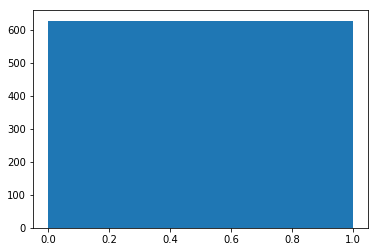

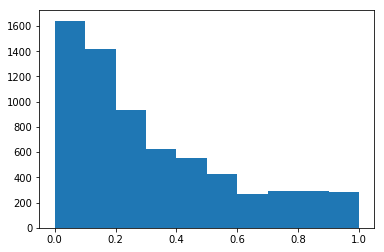

In [20]:
plt.figure()
plt.hist(ESW_star_dict['tstat']["Brain_Non-Myeloid.neuron"][ESW_star_dict['tstat']["Brain_Non-Myeloid.neuron"] > 0])
plt.figure()
plt.hist(ESmu["Brain_Non-Myeloid.neuron"][ESmu["Brain_Non-Myeloid.neuron"] > 0])

Uniform as expected for ESw-star but surprisingly a lot more sloped than I expectd for ESmu

# Check out distribution of various ESw's

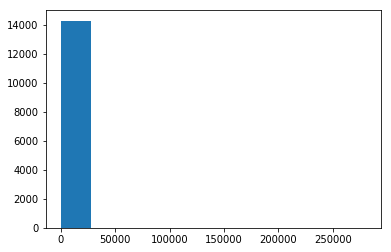

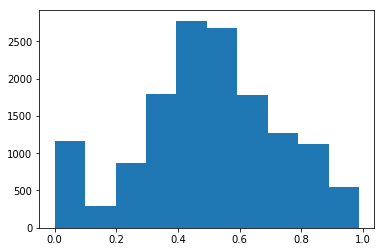

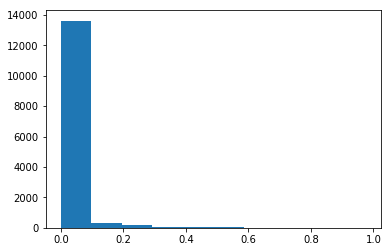

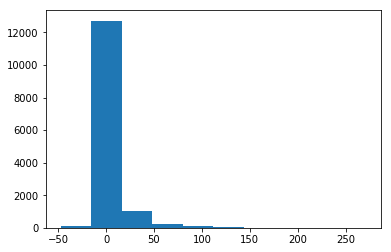

In [40]:
for m in metrics:
    plt.figure()
    plt.hist(ESW_dict[m]["Brain_Non-Myeloid.neuron"])

In [29]:
# Taking a look at the most specific genes
print(ESW_dict['tstat']["Brain_Non-Myeloid.neuron"][ESW_dict['tstat']["Brain_Non-Myeloid.neuron"] > 160])
print(ESW_dict['si']["Brain_Non-Myeloid.neuron"][ESW_dict['si']["Brain_Non-Myeloid.neuron"] > 0.97])
print(ESW_dict['ss']["Brain_Non-Myeloid.neuron"][ESW_dict['ss']["Brain_Non-Myeloid.neuron"] > 0.8])
print(ESW_dict['ges']["Brain_Non-Myeloid.neuron"][ESW_dict['ges']["Brain_Non-Myeloid.neuron"] > 20000])

gene
ENSG00000130643    203.731065
ENSG00000168993    206.150098
ENSG00000110675    187.733669
ENSG00000113327    172.419501
ENSG00000162188    187.940881
ENSG00000120251    194.173050
ENSG00000121905    161.158324
ENSG00000125841    183.515505
ENSG00000021645    207.450962
ENSG00000152932    163.266497
ENSG00000139970    173.040695
ENSG00000132639    251.730541
ENSG00000197457    250.175396
ENSG00000067715    270.429544
Name: Brain_Non-Myeloid.neuron, dtype: float64
gene
ENSG00000006116    0.976954
ENSG00000146360    0.974692
ENSG00000125841    0.987017
ENSG00000174521    0.973197
Name: Brain_Non-Myeloid.neuron, dtype: float64
gene
ENSG00000124237    0.941325
ENSG00000006116    0.906652
ENSG00000080224    0.877371
ENSG00000113327    0.811629
ENSG00000101958    0.971633
ENSG00000180269    0.950731
ENSG00000164082    0.821217
ENSG00000122254    0.916483
ENSG00000125841    0.974015
Name: Brain_Non-Myeloid.neuron, dtype: float64
gene
ENSG00000141433     23546.165284
ENSG00000166862     26

## What about after I slice for significant genes, what is distribution then?

In [47]:
ESW_sig_dict = {}
for m in metrics:
    pvals = ESW_pvals_dict[m]
    esw = ESW_dict[m]
    pval_mask = (pvals <= 0.05).values
    binzero_mask = (esw > 0).values
    # invert mask for values to overwrite with NaN
    mask = ~(pval_mask & binzero_mask)
    
    # masked esw matrix of size n_cells x n_genes
    # significant ESw's are kept, while others are set to NaN
    df_nominal = esw.mask(mask) 
    
    ESW_sig_dict[m] = df_nominal


In [58]:
# Taking a peek at a single metric
ESW_sig_dict[m].head(10)

,Bladder.bladder_cell,Bladder.bladder_urothelial_cell,Brain_Myeloid.macrophage,Brain_Myeloid.microglial_cell,Brain_Non-Myeloid.Bergmann_glial_cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain_pericyte,Brain_Non-Myeloid.endothelial_cell,Brain_Non-Myeloid.neuron,Brain_Non-Myeloid.oligodendrocyte,...,Spleen.macrophage,Thymus.DN1_thymic_pro-T_cell,Thymus.immature_T_cell,Thymus.leukocyte,Tongue.basal_cell_of_epidermis,Tongue.keratinocyte,Trachea.blood_cell,Trachea.endothelial_cell,Trachea.epithelial_cell,Trachea.mesenchymal_cell
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000081791,NaN,NaN,NaN,6.292939,NaN,2.325334,4.372906,10.114011,3.123489,9.535051,...,NaN,NaN,NaN,NaN,10.770278,NaN,NaN,NaN,NaN,NaN
ENSG00000162929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.740330,7.117951,...,NaN,NaN,NaN,NaN,2.392584,NaN,NaN,2.548504,NaN,5.542649
ENSG00000168887,NaN,NaN,NaN,8.533186,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.939088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000162384,11.912439,5.126184,NaN,NaN,NaN,NaN,NaN,8.611844,NaN,NaN,...,NaN,NaN,NaN,NaN,3.284882,3.048152,NaN,NaN,NaN,4.691527
ENSG00000154274,NaN,22.055634,3.843778,134.878988,5.440023,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000265590,NaN,2.288311,NaN,NaN,NaN,NaN,NaN,NaN,6.669366,NaN,...,NaN,3.018366,2.803027,NaN,24.374204,7.043933,NaN,NaN,NaN,NaN
ENSG00000110696,2.703999,11.247579,NaN,NaN,NaN,NaN,4.727016,NaN,12.433303,NaN,...,NaN,1.953187,2.155126,NaN,17.282195,5.146038,NaN,NaN,NaN,NaN
ENSG00000259399,NaN,27.644873,NaN,NaN,NaN,NaN,2.704113,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22.456014,12.408526,NaN,NaN,NaN,NaN
ENSG00000171159,NaN,12.666557,NaN,NaN,NaN,NaN,NaN,2.343250,19.488562,NaN,...,NaN,NaN,3.959518,NaN,NaN,13.108885,NaN,NaN,NaN,NaN


In [49]:
# This should match the previous frequency tables
print((ESW_sig_dict['si']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_sig_dict['ges']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_sig_dict['ss']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_sig_dict['tstat']["Brain_Non-Myeloid.neuron"] > 0).value_counts())
print((ESW_sig_dict['si']["Bladder.bladder_cell"] > 0).value_counts())
print((ESW_sig_dict['tstat']["Bladder.bladder_cell"] > 0).value_counts())
# It does

False    12679
True      1623
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    8537
True     5765
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    10993
True      3309
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    8031
True     6271
Name: Brain_Non-Myeloid.neuron, dtype: int64
False    12916
True      1386
Name: Bladder.bladder_cell, dtype: int64
False    10514
True      3788
Name: Bladder.bladder_cell, dtype: int64


Now to try plotting the current distribution of values, then I will min-max normalise to see if distribution changes

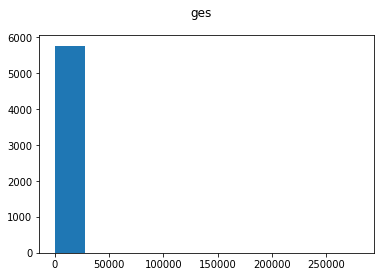

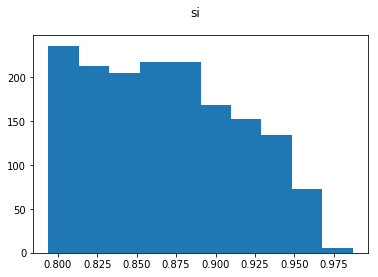

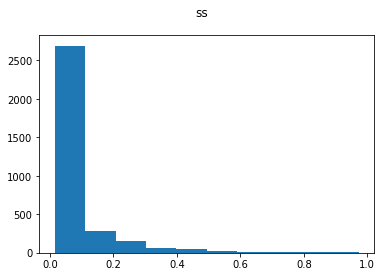

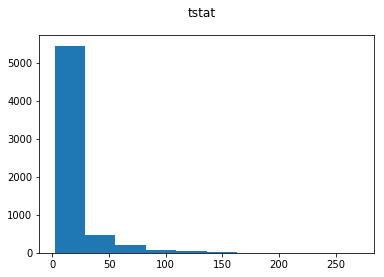

In [55]:
for m in metrics:
    plt.figure()
    plt.hist(ESW_sig_dict[m]["Brain_Non-Myeloid.neuron"][ESW_sig_dict[m]["Brain_Non-Myeloid.neuron"]>0])
    plt.suptitle(m)

In [56]:
# Doing min max normalisation
ESW_sig_norm_dict = {}

for m in metrics:
    df = ESW_sig_dict[m]
    ESW_sig_norm_dict[m] = (df-df.min())/(df.max()-df.min())

In [59]:
# Take a peek
ESW_sig_norm_dict[m].head()

,Bladder.bladder_cell,Bladder.bladder_urothelial_cell,Brain_Myeloid.macrophage,Brain_Myeloid.microglial_cell,Brain_Non-Myeloid.Bergmann_glial_cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain_pericyte,Brain_Non-Myeloid.endothelial_cell,Brain_Non-Myeloid.neuron,Brain_Non-Myeloid.oligodendrocyte,...,Spleen.macrophage,Thymus.DN1_thymic_pro-T_cell,Thymus.immature_T_cell,Thymus.leukocyte,Tongue.basal_cell_of_epidermis,Tongue.keratinocyte,Trachea.blood_cell,Trachea.endothelial_cell,Trachea.epithelial_cell,Trachea.mesenchymal_cell
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000081791,NaN,NaN,NaN,0.001487,NaN,0.001253,0.012009,0.024441,0.004630,0.013408,...,NaN,NaN,NaN,NaN,0.022307,NaN,NaN,NaN,NaN,NaN
ENSG00000162929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032993,0.008996,...,NaN,NaN,NaN,NaN,0.001463,NaN,NaN,0.010594,NaN,0.020791
ENSG00000168887,NaN,NaN,NaN,0.003594,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.017913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000162384,0.041859,0.006620,NaN,NaN,NaN,NaN,NaN,0.020064,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003683,0.005115,NaN,NaN,NaN,0.015943
ENSG00000154274,NaN,0.041738,0.051584,0.122435,0.023391,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


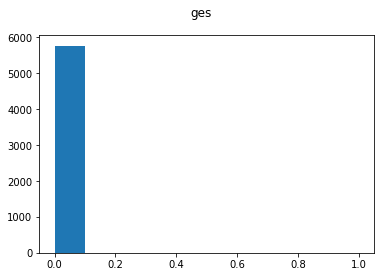

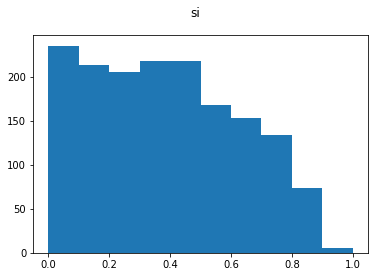

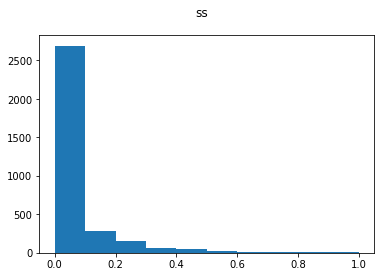

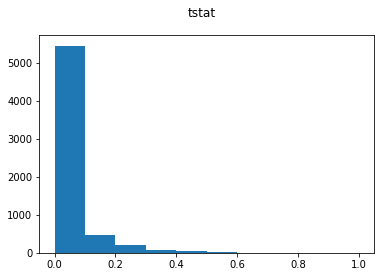

In [62]:
for m in metrics:
    plt.figure()
    plt.hist(ESW_sig_norm_dict[m]["Brain_Non-Myeloid.neuron"][ESW_sig_norm_dict[m]["Brain_Non-Myeloid.neuron"]>0])
    plt.suptitle(m)

Distribution of values looks the same so will try quantile normalising. Can do two ways:
1. I quantile normalise all 4 metrics individually and then for my ESmuQ1 I take the mean for each gene
2. I take the mean for each gene then fit it to a quantile normalised ranking for my ESmuQ2

In [101]:
# First I need to get the ranking
# Done according to this but looping over each col https://stackoverflow.com/a/41078786/7799456
# I do this by making a new dataframe of ranks for each cell type
quant_rank_df = pd.DataFrame()
for cell in ESmu.columns:
    df = pd.DataFrame()
    for m in metrics:
        df[m] = ESW_sig_norm_dict[m][cell].fillna(0)
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(float)).mean()
    quant_rank_df[cell] = rank_mean
rank_mean.tail()

14298.0    0.637140
14299.0    0.688642
14300.0    0.749394
14301.0    0.807567
14302.0    1.000000
dtype: float64

Text(0.5,0.98,'Quantile ranking')

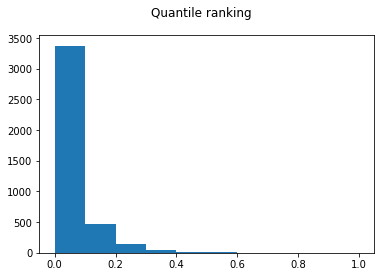

In [102]:
plt.figure()
plt.hist(rank_mean[rank_mean>0])
plt.suptitle('Quantile ranking')

In [103]:
print((rank_mean > 0).value_counts())
# Commented below are values without fillna(0)
# 4061.0    0.701754
# 4062.0    0.707439
# 4063.0    0.751144
# 4064.0    0.764000
# 4065.0    0.812429
# 4066.0    0.827813
# 4067.0    1.000000
rank_mean.tail()

False    10236
True      4066
dtype: int64


14298.0    0.637140
14299.0    0.688642
14300.0    0.749394
14301.0    0.807567
14302.0    1.000000
dtype: float64

For some reason the quantile normalisation changes when I use fillna(0) vs no fillna.
It should take the #1 ranking as the mean position of all top genes.
And the #2 ranking as the mean of all second top genes. So whether there are 0s or not shouldn't have an effect

In [104]:
# What is the mean of the 2nd top gene of every column (for the last cell only

# Create a function to return the top three values of a series:
# https://stackoverflow.com/questions/20477190/get-top-biggest-values-from-each-column-of-the-pandas-dataframe
def sorted(s, num):
    tmp = s.sort_values(ascending=False)[:num]  # earlier s.order(..)
    tmp.index = range(num)
    return tmp
print(df.apply(lambda x: sorted(x, 3)))

df.apply(lambda x: sorted(x, 3)).mean(axis=1)


        ges        si        ss     tstat
0  1.000000  1.000000  1.000000  1.000000
1  0.556416  0.966341  0.879701  0.827813
2  0.411853  0.966238  0.807058  0.812429


0    1.000000
1    0.807567
2    0.749394
dtype: float64

I'm not sure exactly what the cause it but it seems based on the above that filling NAs with 0s produces the correct quantile normalisation. So I will use that.

In [105]:
quant_rank_df

,Bladder.bladder_cell,Bladder.bladder_urothelial_cell,Brain_Myeloid.macrophage,Brain_Myeloid.microglial_cell,Brain_Non-Myeloid.Bergmann_glial_cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain_pericyte,Brain_Non-Myeloid.endothelial_cell,Brain_Non-Myeloid.neuron,Brain_Non-Myeloid.oligodendrocyte,...,Spleen.macrophage,Thymus.DN1_thymic_pro-T_cell,Thymus.immature_T_cell,Thymus.leukocyte,Tongue.basal_cell_of_epidermis,Tongue.keratinocyte,Trachea.blood_cell,Trachea.endothelial_cell,Trachea.epithelial_cell,Trachea.mesenchymal_cell
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Now that I have my quantile rankings I will apply try producing both ESmuQ1 and ESmuQ2

In [114]:
#ESmuQ2 - Taking the mean of all 4 metrics then applying the ranking (I do this first because it is easier)
# Computing mean across 4 dataframes according to this https://stackoverflow.com/a/25058102/7799456
df_concat_esmuq2 = pd.concat((ESW_sig_norm_dict['tstat'],
                            ESW_sig_norm_dict['ss'],
                            ESW_sig_norm_dict['si'],
                            ESW_sig_norm_dict['ges']))
by_row_index_esmuq2 = df_concat_esmuq2.groupby(df_concat_esmuq2.index)
df_means_esmuq2 = by_row_index_esmuq2.mean()
df_means_esmuq2

,Bladder.bladder_cell,Bladder.bladder_urothelial_cell,Brain_Myeloid.macrophage,Brain_Myeloid.microglial_cell,Brain_Non-Myeloid.Bergmann_glial_cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain_pericyte,Brain_Non-Myeloid.endothelial_cell,Brain_Non-Myeloid.neuron,Brain_Non-Myeloid.oligodendrocyte,...,Spleen.macrophage,Thymus.DN1_thymic_pro-T_cell,Thymus.immature_T_cell,Thymus.leukocyte,Tongue.basal_cell_of_epidermis,Tongue.keratinocyte,Trachea.blood_cell,Trachea.endothelial_cell,Trachea.epithelial_cell,Trachea.mesenchymal_cell
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.006275,0.009886,NaN,NaN,0.013962,4.811083e-03,NaN,NaN,0.003777,NaN,...,NaN,NaN,NaN,NaN,0.000048,6.935043e-03,NaN,0.023670,0.017706,0.032146
ENSG00000000005,NaN,NaN,NaN,NaN,NaN,3.599869e-01,NaN,0.313362,0.076820,NaN,...,NaN,NaN,NaN,NaN,NaN,2.668259e-02,NaN,NaN,0.342859,0.251595
ENSG00000000457,NaN,0.000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.002714,NaN,0.000782,2.904718e-07,NaN,NaN,NaN,NaN
ENSG00000000460,NaN,NaN,NaN,0.003216,NaN,NaN,NaN,NaN,0.004389,NaN,...,NaN,NaN,0.004714,NaN,0.000367,NaN,0.001401,NaN,0.002284,NaN
ENSG00000000938,NaN,NaN,0.057086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.038239,NaN,NaN,NaN
ENSG00000001036,NaN,0.022328,NaN,0.020671,0.001794,6.013012e-03,NaN,NaN,NaN,NaN,...,0.003715,NaN,NaN,NaN,0.006474,7.313855e-03,0.003754,NaN,NaN,NaN
ENSG00000001084,0.000002,0.052080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.026193,3.020292e-02,0.001690,NaN,0.017765,0.001310
ENSG00000001167,NaN,NaN,0.021111,0.007091,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000001461,NaN,0.000010,NaN,NaN,NaN,NaN,NaN,0.007630,0.010549,0.011127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
ESmuQ2 = pd.DataFrame()
for col in ESmu.columns:
    ranked_col = df_means_esmuq2[col].fillna(0).rank(method='min')
    ESmuQ2[col] = ranked_col.fillna(0).astype(int).map(quant_rank_df[col])
# quant_rank_df[col]
ESmuQ2

,Bladder.bladder_cell,Bladder.bladder_urothelial_cell,Brain_Myeloid.macrophage,Brain_Myeloid.microglial_cell,Brain_Non-Myeloid.Bergmann_glial_cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain_pericyte,Brain_Non-Myeloid.endothelial_cell,Brain_Non-Myeloid.neuron,Brain_Non-Myeloid.oligodendrocyte,...,Spleen.macrophage,Thymus.DN1_thymic_pro-T_cell,Thymus.immature_T_cell,Thymus.leukocyte,Tongue.basal_cell_of_epidermis,Tongue.keratinocyte,Trachea.blood_cell,Trachea.endothelial_cell,Trachea.epithelial_cell,Trachea.mesenchymal_cell
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.001437,3.225912e-03,0.000000,0.000000,0.006050,0.000374,0.000000,0.000000,0.001302,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.249910e-03,0.000000,0.006045,0.006303,0.008680
ENSG00000000005,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.341874,0.000000,0.203329,0.071794,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.793173e-03,0.000000,0.000000,0.354088,0.244990
ENSG00000000457,0.000000,1.582099e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000e+00,0.000000,0.000000,0.000000,0.000000
ENSG00000000460,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001589,0.000000,...,0.000000,0.000000,0.000484,0.000000,0.000004,0.000000e+00,0.000000,0.000000,0.000152,0.000000
ENSG00000000938,0.000000,0.000000e+00,0.022334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.010872,0.000000,0.000000,0.000000
ENSG00000001036,0.000000,6.146879e-03,0.000000,0.004522,0.000033,0.000836,0.000000,0.000000,0.000000,0.000000,...,0.000281,0.000000,0.000000,0.000000,0.002046,2.412039e-03,0.000000,0.000000,0.000000,0.000000
ENSG00000001084,0.000000,2.884640e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.008651,9.638826e-03,0.000000,0.000000,0.006334,0.000000
ENSG00000001167,0.000000,0.000000e+00,0.005196,0.001363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
ENSG00000001461,0.000000,4.116391e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.001079,0.004460,0.001960,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000


In [135]:
# Checking if the Bladder urothelial cells really do have so many tiny values
quant_rank_df['Bladder.bladder_urothelial_cell'][14302-5429:]
# They do!

8873.0     0.000000e+00
8874.0     1.171064e-09
8875.0     2.268096e-09
8876.0     2.549633e-09
8877.0     3.483937e-09
8878.0     4.052603e-09
8879.0     5.622606e-09
8880.0     1.059298e-08
8881.0     1.283953e-08
8882.0     1.474932e-08
8883.0     1.498333e-08
8884.0     1.544599e-08
8885.0     1.663075e-08
8886.0     1.907794e-08
8887.0     2.160796e-08
8888.0     2.579657e-08
8889.0     2.721911e-08
8890.0     2.999669e-08
8891.0     3.016199e-08
8892.0     3.217949e-08
8893.0     3.221376e-08
8894.0     3.305574e-08
8895.0     3.381446e-08
8896.0     3.456774e-08
8897.0     3.700919e-08
8898.0     3.723875e-08
8899.0     3.919608e-08
8900.0     3.961267e-08
8901.0     4.057772e-08
8902.0     4.058261e-08
               ...     
14273.0    3.536257e-01
14274.0    3.573729e-01
14275.0    3.582901e-01
14276.0    3.633952e-01
14277.0    3.776912e-01
14278.0    3.798719e-01
14279.0    3.842441e-01
14280.0    3.878903e-01
14281.0    3.931285e-01
14282.0    3.982703e-01
14283.0    4.006

In [136]:
#ESmuQ1 - Quantile ranking all 4 metrics then taking the mean across them as my final metric

# First I quantile normalise each metric and store the resulting dataframes in a dictionary
ESmu_q1_dict = {'tstat':pd.DataFrame(),
               'si':pd.DataFrame(),
               'ss':pd.DataFrame(),
               'ges':pd.DataFrame()}
for col in ESmu.columns:
    for m in metrics:
        ranked_col = ESW_sig_norm_dict[m][col].fillna(0).rank(method='min')
        ESmu_q1_dict[m][col] = ranked_col.fillna(0).astype(int).map(quant_rank_df[col])

In [140]:
# Then I concatenate all these dataframes and take the mean
df_concat_esmuq1 = pd.concat((ESmu_q1_dict['tstat'],
                            ESmu_q1_dict['ss'],
                            ESmu_q1_dict['si'],
                            ESmu_q1_dict['ges']))
by_row_index_esmuq1 = df_concat_esmuq1.groupby(df_concat_esmuq1.index)
ESmuQ1 = by_row_index_esmuq1.mean()
ESmuQ1.head()

,Bladder.bladder_cell,Bladder.bladder_urothelial_cell,Brain_Myeloid.macrophage,Brain_Myeloid.microglial_cell,Brain_Non-Myeloid.Bergmann_glial_cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain_pericyte,Brain_Non-Myeloid.endothelial_cell,Brain_Non-Myeloid.neuron,Brain_Non-Myeloid.oligodendrocyte,...,Spleen.macrophage,Thymus.DN1_thymic_pro-T_cell,Thymus.immature_T_cell,Thymus.leukocyte,Tongue.basal_cell_of_epidermis,Tongue.keratinocyte,Trachea.blood_cell,Trachea.endothelial_cell,Trachea.epithelial_cell,Trachea.mesenchymal_cell
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.001829,1.715377e-02,0.000000,0.000000,0.009542,0.001196,0.0,0.000000,0.000236,0.0,...,0.0,0.0,0.000000,0.0,0.000003,2.355106e-03,0.000000,0.012562,0.020330,0.046492
ENSG00000000005,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.026509,0.0,0.025045,0.009772,0.0,...,0.0,0.0,0.000000,0.0,0.000000,4.587304e-03,0.000000,0.000000,0.320043,0.260430
ENSG00000000457,0.000000,4.505584e-07,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000170,0.0,0.000323,1.815449e-08,0.000000,0.000000,0.000000,0.000000
ENSG00000000460,0.000000,0.000000e+00,0.000000,0.005674,0.000000,0.000000,0.0,0.000000,0.004064,0.0,...,0.0,0.0,0.006068,0.0,0.000605,0.000000e+00,0.006331,0.000000,0.001630,0.000000
ENSG00000000938,0.000000,0.000000e+00,0.073894,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.025750,0.000000,0.000000,0.000000


In [141]:
# Saving now - can make into multigenesets tomorrow
ESmuQ1.to_csv('ESmuQ1.csv', header=True)
ESmuQ2.to_csv('ESmuQ2.csv',header=True)

In [9]:
# # Reading them back in, not necessary if you're running dataframe from the top
ESmuQ1 = pd.read_csv('ESmuQ1.csv', index_col=0)
ESmuQ2 = pd.read_csv('ESmuQ2.csv', index_col=0)
# ESmuQ1.head()

In [10]:
ESmuQs = [ESmuQ1, ESmuQ2]
ESmuQ_names = ["ESmuQ1", "ESmuQ2"]
name_of_dataset = 'tabula_muris'
bench_date = '190730'
binary_or_cont = 'continuous'

for i in range(2):
    es_metric = ESmuQ_names[i]
    esmu_df = ESmuQs[i]
    esmu_df.reset_index(inplace=True)
    esmu_long_df = pd.melt(esmu_df,id_vars=['gene'],var_name='annotation', value_name='specificity')
    multi_geneset_celltypes = esmu_long_df[['annotation','gene','specificity']]
    multi_geneset_celltypes = multi_geneset_celltypes.loc[multi_geneset_celltypes.specificity>0]
    multi_geneset_celltypes.to_csv('../../data/benchmark_multigenesets/multi_geneset.{}.{}.{}.{}.txt'.format(name_of_dataset, es_metric, binary_or_cont, bench_date),header=None, index=False,sep='\t')
multi_geneset_celltypes.head()

,annotation,gene,specificity
0,Bladder.bladder_cell,ENSG00000000003,0.001437
11,Bladder.bladder_cell,ENSG00000001617,0.002109
16,Bladder.bladder_cell,ENSG00000002016,0.000298
17,Bladder.bladder_cell,ENSG00000002330,0.002767
25,Bladder.bladder_cell,ENSG00000002933,0.059528
